In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [8]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

# Import CSV file

In [9]:
# Using Google Colab
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/MLH/full_cohort.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# To recreate this code on own machine, comment out previous cell and run this instead
# file_path = '/full_cohort.csv'

In [11]:
# Read CSV file
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  2016 non-null   int64  
 1   hadm_id                     2016 non-null   int64  
 2   age                         2016 non-null   int64  
 3   gender                      2016 non-null   object 
 4   weight                      2016 non-null   float64
 5   height                      1130 non-null   float64
 6   n_stays                     2016 non-null   int64  
 7   sum_los                     2016 non-null   float64
 8   rec_temperature_max_F       1995 non-null   float64
 9   sbp_max                     1130 non-null   float64
 10  heart_rate_avg              1995 non-null   float64
 11  respiratory_rate_avg        2016 non-null   float64
 12  wbc_count                   945 non-null    float64
 13  lymphocyte_percentage       1066 

In [12]:
readmission_count = df['has_readmission'].value_counts().get(1, 0)

print(f"Cohort Size: {len(df)}")
print(f"Number of readmission: {readmission_count}, {round(100*readmission_count/len(df),3)}% of cohort")
print(f"Number of non-readmission: {len(df) - readmission_count}")

non_readmission = len(df)-readmission_count

Cohort Size: 2016
Number of readmission: 221, 10.962% of cohort
Number of non-readmission: 1795


# Data preprocessing

## Impute with KNN

In [13]:
# Select only the columns with lab results for imputation
features = df.columns.tolist()
to_remove = (['has_readmission', 'age', 'gender', 'weight', 'height', 'sum_los', 'has_hypertension', 'has_diabetes', 'has_af'])
impute_columns = [f for f in features if f not in to_remove]

lab_data = df[impute_columns]

print(df[impute_columns].isnull().sum())

dataset = df.copy()

# Demographic
# Replace Gender with binary (0: Male, 1: Female)
dataset.loc[dataset['gender']=='M','gender'] = int(0)
dataset.loc[dataset['gender']=='F','gender'] = int(1)
dataset['gender'] = dataset['gender'].astype(int)

# Physical measurements
dataset.loc[dataset['weight'].isnull(), 'weight'] = dataset['weight'].median()
dataset.loc[dataset['height'].isnull(), 'height'] = dataset['height'].median()

# ICU Stay data
dataset.loc[dataset['n_stays'].isnull(), 'n_stays'] = dataset['n_stays'].median()
dataset.loc[dataset['sum_los'].isnull(), 'sum_los'] = dataset['sum_los'].median()

# Comorbidities
dataset.loc[dataset['has_hypertension'].isnull(),'has_hypertension'] = int(0)
dataset.loc[dataset['has_diabetes'].isnull(),'has_diabetes'] = int(0)
dataset.loc[dataset['has_af'].isnull(),'has_af'] = int(0)

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
lab_data_imputed = imputer.fit_transform(lab_data)

# Convert the imputed data back to a DataFrame
dataset[impute_columns] = pd.DataFrame(lab_data_imputed, columns=impute_columns)

# Check if there are still missing values in the lab columns
print(dataset[impute_columns].isnull().sum())

subject_id                       0
hadm_id                          0
n_stays                          0
rec_temperature_max_F           21
sbp_max                        886
heart_rate_avg                  21
respiratory_rate_avg             0
wbc_count                     1071
lymphocyte_percentage          950
rbc_count                     1031
lactate_level_max              564
alb_level_min                  857
trt_max                       1294
glucose_extreme_count           18
sodium_extreme_count            16
charlson_comorbidity_index       0
dtype: int64
subject_id                    0
hadm_id                       0
n_stays                       0
rec_temperature_max_F         0
sbp_max                       0
heart_rate_avg                0
respiratory_rate_avg          0
wbc_count                     0
lymphocyte_percentage         0
rbc_count                     0
lactate_level_max             0
alb_level_min                 0
trt_max                       0
glucose_ext

In [14]:
# Display summary statistics after imputation
cohort = dataset.drop(['subject_id', 'hadm_id', 'n_stays'], axis = 1)
summary_stats = cohort.describe()
display(summary_stats)

,age,gender,weight,height,sum_los,rec_temperature_max_F,sbp_max,heart_rate_avg,respiratory_rate_avg,wbc_count,...,lactate_level_max,alb_level_min,trt_max,glucose_extreme_count,sodium_extreme_count,has_hypertension,has_diabetes,has_af,charlson_comorbidity_index,has_readmission
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,...,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,69.221726,0.472718,81.160839,168.193056,5.454389,100.365188,931.127282,80.194245,18.889359,26.101091,...,305.081687,3.196776,0.844032,2.634028,5.177083,0.584325,0.334821,0.381448,0.098710,0.109623
std,14.947350,0.499379,23.850315,10.429582,7.184710,19.722398,6898.428481,30.495188,3.209989,41.132680,...,614.642930,2.084902,1.641614,5.255317,9.676975,0.492960,0.472045,0.485863,0.298347,0.312497
min,19.000000,0.000000,1.000000,0.000000,0.090417,35.600000,-12.000000,42.750000,8.558621,0.000000,...,0.600000,0.900000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,0.000000,66.375000,168.000000,1.397772,98.800000,165.000000,71.324995,16.616824,5.200000,...,3.975000,2.800000,0.114000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,71.000000,0.000000,78.225000,168.000000,2.808617,99.600000,185.000000,79.161458,18.555556,14.000000,...,203.000000,3.110000,0.371000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,81.000000,1.000000,92.516667,170.000000,6.485868,101.000000,208.000000,87.528143,20.946528,32.400000,...,328.625000,3.500000,0.872000,3.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,91.000000,1.000000,510.000000,244.000000,66.584236,978.000000,110160.000000,1313.326531,35.327586,809.000000,...,9990.000000,86.300000,23.500000,66.000000,132.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# ML Methods

In [15]:
def print_tuning_info(clf):
    print(clf.best_estimator_)
    print("best_params: ", clf.best_params_)
    print("best_score: ", clf.best_score_)

def evaluate(y_test, y_pred, model):
    plt.figure(figsize=(12, 5))

    # Plot the confusion matrix
    plt.subplot(1, 2, 1)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                        display_labels=['0: No readmission', '1: Readmission'])
    cm_display.plot(cmap="Blues", ax=plt.gca())  # Use plt.gca() to ensure it plots on the current subplot
    plt.title(f"Confusion Matrix of {model}")

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Plot the ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='red', label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {model}')
    plt.legend(loc="lower right")

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

## Split data

In [16]:
# Define features and target variable
features = cohort.columns.tolist()
features.remove('has_readmission')

target = 'has_readmission'

X = cohort[features]  # Feature matrix
y = cohort[target]    # Target variable


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Fit and transform only on training data
X_test = scaler.transform(X_test) # Transform (only) on test data

## Random Forest

In [17]:
def random_forest_classifier(X_train_resampled, y_train_resampled,
                             X_test_vec, y_test):
  # Train a random forest classifier
  rf_classifier = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=90089)
  rf_classifier.fit(X_train_resampled, y_train_resampled)

  # Model evaluation
  y_pred = rf_classifier.predict(X_test_vec)
  print(classification_report(y_test, y_pred))

  evaluate(y_test, y_pred, 'Random Forest')

In [18]:
K_FOLDS = 5

# RF
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, 100, 200]
}

rf_clf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=90089),
    param_grid=rf_params,
    cv=K_FOLDS,
    refit=True,
    n_jobs=1,
    verbose=2,
    scoring='f1_weighted'
)

rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.7s
[CV] END .....................max_depth=10, n_es

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=90089),
             n_jobs=1,
             param_grid={'max_depth': [10, 50, 100, 200],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=2)

Accuracy: 0.9133663366336634
F-score: 0.6337451757453312
precision 1.0
recall 0.18604651162790697
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       361
           1       1.00      0.19      0.31        43

    accuracy                           0.91       404
   macro avg       0.96      0.59      0.63       404
weighted avg       0.92      0.91      0.89       404



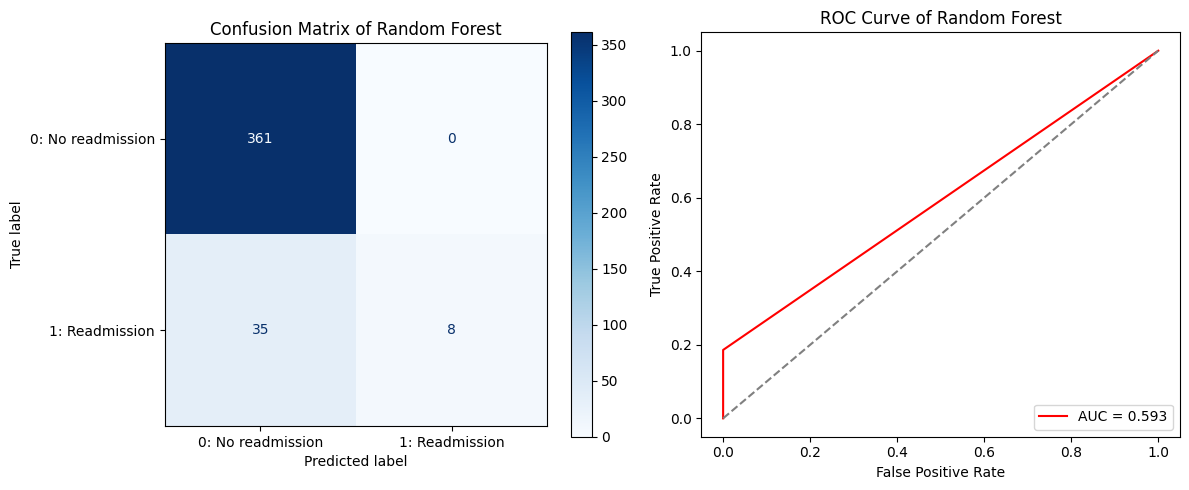

In [19]:
# Plain RF

best_rf_model = RandomForestClassifier(n_estimators=rf_clf.best_params_["n_estimators"], max_depth=rf_clf.best_params_["max_depth"])
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F-score:", f1_score(y_test, y_pred, average='macro'))
print('precision', precision_score(y_test, y_pred)),
print('recall', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
evaluate(y_test, y_pred, 'Random Forest')

y_train_resampled: Counter({0: 1434, 1: 1434})
Accuracy: 0.8465346534653465
F-score: 0.626795399010668
precision 0.3137254901960784
recall 0.37209302325581395
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       361
           1       0.31      0.37      0.34        43

    accuracy                           0.85       404
   macro avg       0.62      0.64      0.63       404
weighted avg       0.86      0.85      0.85       404



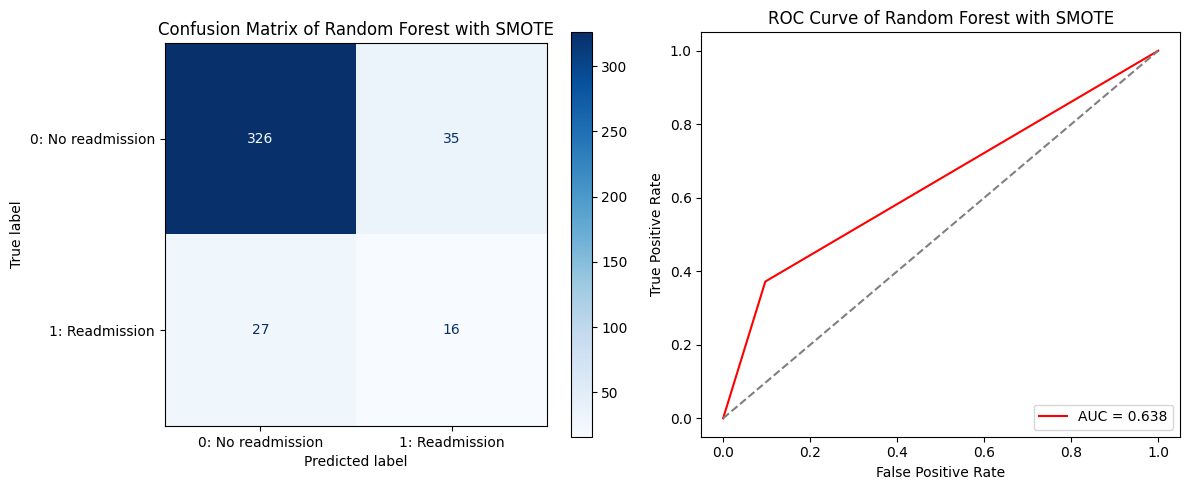

In [20]:
# RF with Oversampling

smote = SMOTE(random_state=90089)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# summarize class distribution after SMOTE
print(f'y_train_resampled: {Counter(y_train_resampled)}')

best_rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F-score:", f1_score(y_test, y_pred, average='macro'))
print('precision', precision_score(y_test, y_pred)),
print('recall', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
evaluate(y_test, y_pred, 'Random Forest with SMOTE')

Accuracy: 0.8465346534653465
F-score: 0.626795399010668
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       361
           1       0.25      0.42      0.31        43

    accuracy                           0.80       404
   macro avg       0.59      0.63      0.60       404
weighted avg       0.85      0.80      0.82       404



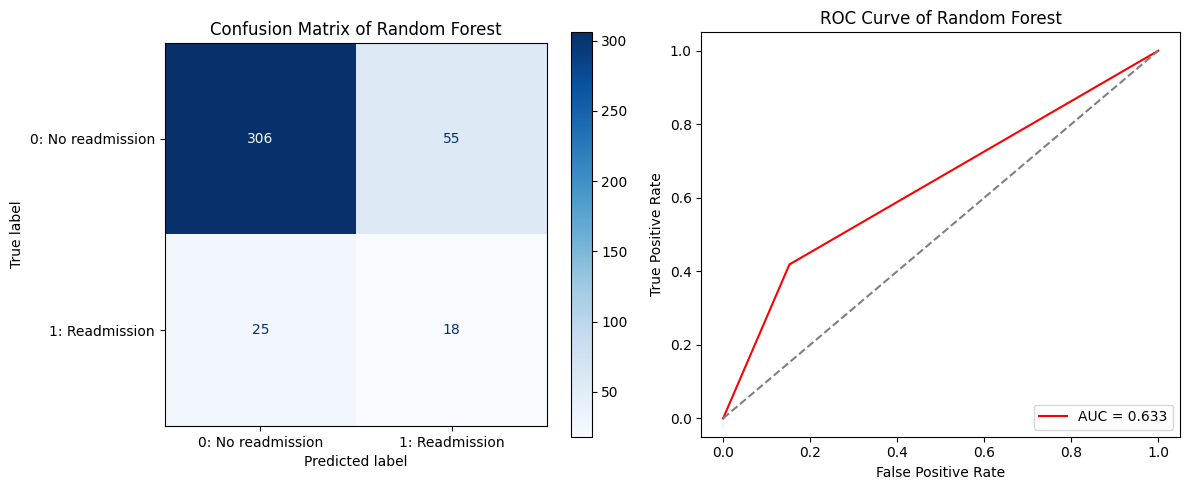

In [21]:
# RF with Undersampling

# Apply SMOTE with undersampling on the training data
smote_enn = SMOTEENN(random_state=90089)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F-score:", f1_score(y_test, y_pred, average='macro'))
random_forest_classifier(X_resampled, y_resampled, X_test, y_test)

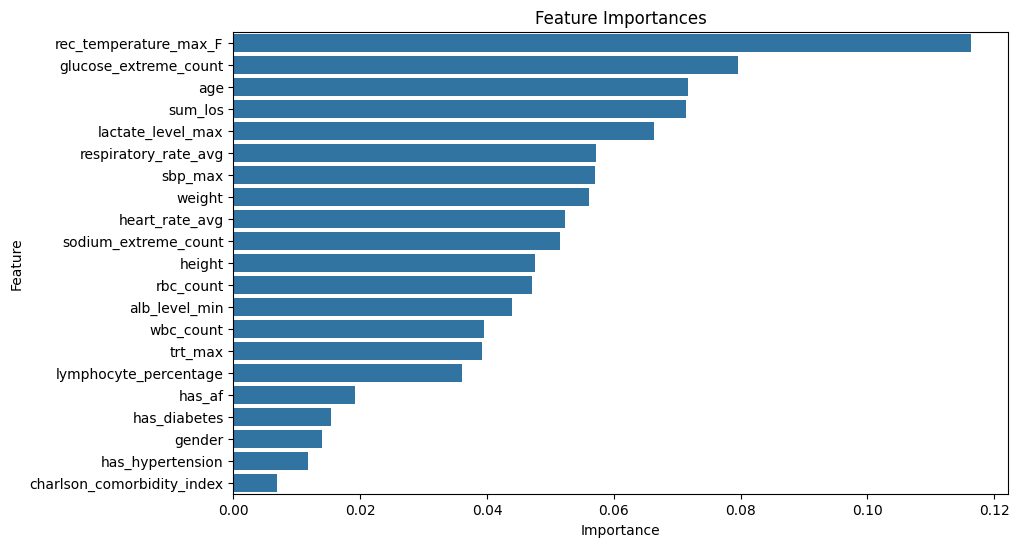

In [24]:
# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importances')
plt.show()